## Imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import copy

from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner

# Correct sequence fall off detection
We have a property in the program that lets us pass in a "truth" set. This truth set we will pull from Delong lab and will primarily be used for debugging our hybrids. The steps we need to take:
1. Load in SpectrumMill results and create a "truth" set where each entry in this json file has the form:
```json
{
    spectrum_id: {
        "sequence": str, 
        "hybrid": bool
    }
}
```
2. Run hyped search with the "truth_set" param set to the file generated in step 1
3. Load in the file created (output_dir + 'fall_off.json')
4. Run all analysis

## Constants

In [6]:
spec_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredSpec/'
db_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredNOD2.fasta'
output_dir = '/Users/zacharymcgrath/Desktop/Experiment output/fall_off/'
specmil_truth_set = '/Users/zacharymcgrath/Downloads/NOD2_E3_results.ssv'

minPep = 3
maxPep = 30
tolerance = 20
relative_abundance_filter = 0.0
precursor_tolerance = 3
peak_filter = 25
verbose = True


## 1. Load in SpectrumMill and create truth file

In [7]:
# first load in the results
specmil_results = pd.read_csv(specmil_truth_set, sep=';')
specmil_results.head(5)


,number,filename,parent_charge,score,deltaForwardReverseScore,deltaRank1Rank2Score,percent_scored_peak_intensity,totalIntensity,previous_aa,sequence,next_aa,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,species,entry_name
0,1,NOD2_E3.13446.13477.2,2,10.10,10.10,9.91,84.5,183000.0,(E),DPQVEQLEL,(-),48.35,26.0,535.7725,MOUSE,ins1C18
1,2,NOD2_E3.18005.18246.2,2,12.84,11.07,12.84,97.8,40000000.0,(G),DLQTLALEVA,(-),65.78,29.0,536.8007,MOUSE,ins1C3
2,3,NOD2_E3.13729.13828.2,2,12.43,6.68,7.86,90.7,2200000.0,(G),DLQTLALE,(-),49.52,22.0,451.7460,MOUSE,ins1C5
3,4,NOD2_E3.15226.15503.2,2,11.17,6.21,6.67,89.1,1740000.0,(G),DLQTLAL,(-),54.38,169.0,387.2243,MOUSE,ins1C6
4,5,NOD2_E3.21510.21510.2,2,12.54,12.54,12.54,91.3,91900.0,(G),DLQTLALLL,(D),76.92,3.0,500.3081,MOUSE,HYBRID: mouse ins1C PQVEQLELGGSPGDLQTLAL-LLDEG...


In [8]:
def get_hybrid_seq(peptide: str, protein: str) -> str:
    '''
    From a hybrid protein that looks like 
    ABCDE-FGHI
    
    and a peptide that looks like
    DEFGH
    
    extract 
    DE-FGH
    
    Inputs:
        peptide: (str) the desired subseq
        protein: (str) the full string with the hybrid character 
    Outputs:
        new peptide string
    '''
    # copy the protein
    prot_cp = copy.deepcopy(protein)
    
    # find the subseq
    peptide_idx = protein.replace('-', '').replace('(', '').replace(')', '').index(peptide)
    
    # get that stretch of prot
    add_on = len(peptide) + (1 if '-' in protein else 2)
    
    return protein[peptide_idx:peptide_idx+add_on]

In [9]:
# json to store results in
json_truth_set = {}

# go through every entry in the database, find out if its a hybrid and get the sequence, ided by the filename
for idx, row in specmil_results.iterrows():
    
    # all the ids seem to have .pkl at the end of them so add that
    key = row['filename'] + '.pkl'
    hybrid = 'HYBRID' in row['entry_name']
    
    seq = row['sequence'] if not hybrid else get_hybrid_seq(row['sequence'], row['entry_name'])
    
    json_truth_set[key] = {
        'hybrid': hybrid, 
        'sequence': seq
    }
    
full_truth_path = output_dir + 'specmil_truth_set.json'
    
json.dump(json_truth_set, open(full_truth_path, 'w'))

## 2. Run hypedsearch with the truth set

In [6]:
truth_run_params = {
    'spectra_folder': spec_file,
    'database_file': db_file,
    'output_dir': output_dir,
    'min_peptide_len': minPep,
    'max_peptide_len': maxPep,
    'tolerance': tolerance,
    'precursor_tolerance': precursor_tolerance,
    'peak_filter': peak_filter, 
    'relative_abundance_filter': relative_abundance_filter,
    'digest': 'trypsin', 
    'missed_cleavages': 2,
    'verbose': verbose,
    'DEBUG': False,
    'truth_set': full_truth_path
}

runner.run(truth_run_params)


DEV set to True. 
Tracking when correct answer falls off. 
Results are stored in a json named 'fall_off.json' in the specified output directory
File will be of the form

    {
        spectrum_id: {
            hybrid: bool, 
            truth_sequence: str, 
            fall_off_operation: str, 
        }
    }
            
Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 280/280 [100%]
Sorting the set of protein masses...
Initializing other processors...
Done.
Creating an alignment for 1084/1086 [99%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/Experiment output/fall_off/...
Could not make an alignment for 552/1086 spectra (50%)


## 3. Load in the fall off results

In [10]:
fall_off_results = json.load(open(output_dir + 'fall_off.json'))
len(fall_off_results)

552

## 4. Run all analysis
1. Plot the number of results that fell into each category
2. Separate them by hybrid and non hybrd

### 4.1

In [11]:
# first load them into dictionaries by {type: [seq]}
typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    typed_fall_off[entry['fall_off_operation']].append((_id, entry))
    

<BarContainer object of 4 artists>

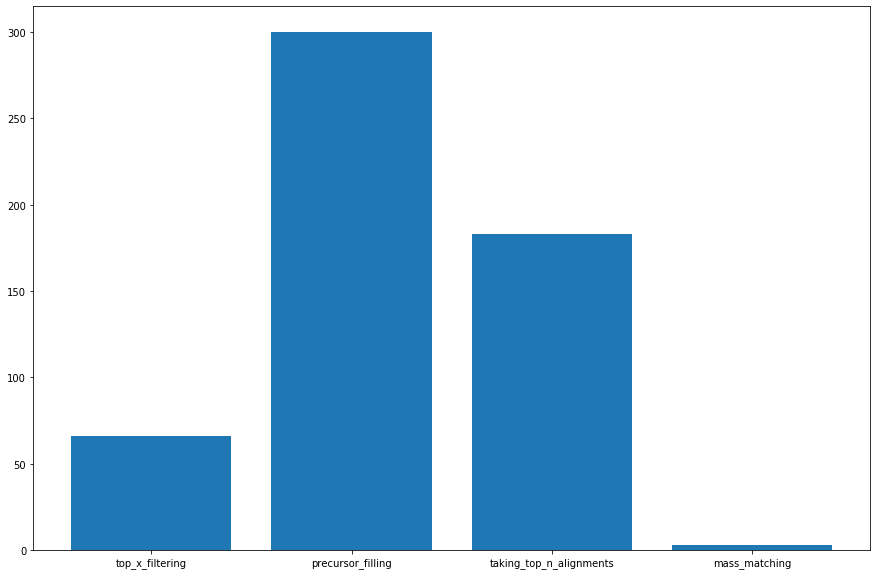

In [12]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)


### 4.2 by hybrid 

In [13]:
hybrid_typed_fall_off = defaultdict(list)
nonhybrid_typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    
    if entry['hybrid']:
        hybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))
        
    else:
        nonhybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))

Text(0.5, 1.0, 'Hybrid fall off positions')

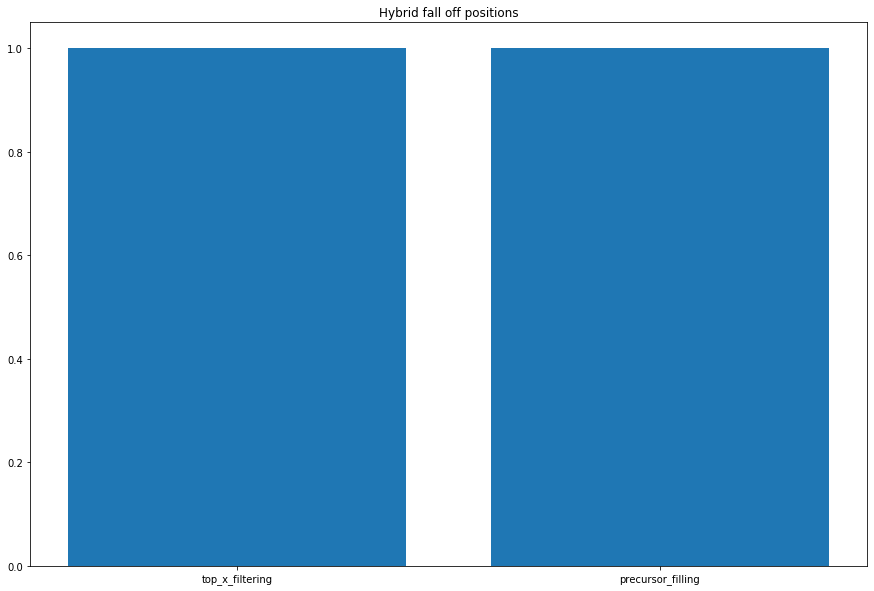

In [14]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(hybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Hybrid fall off positions')

Text(0.5, 1.0, 'Non hybrid fall off positions')

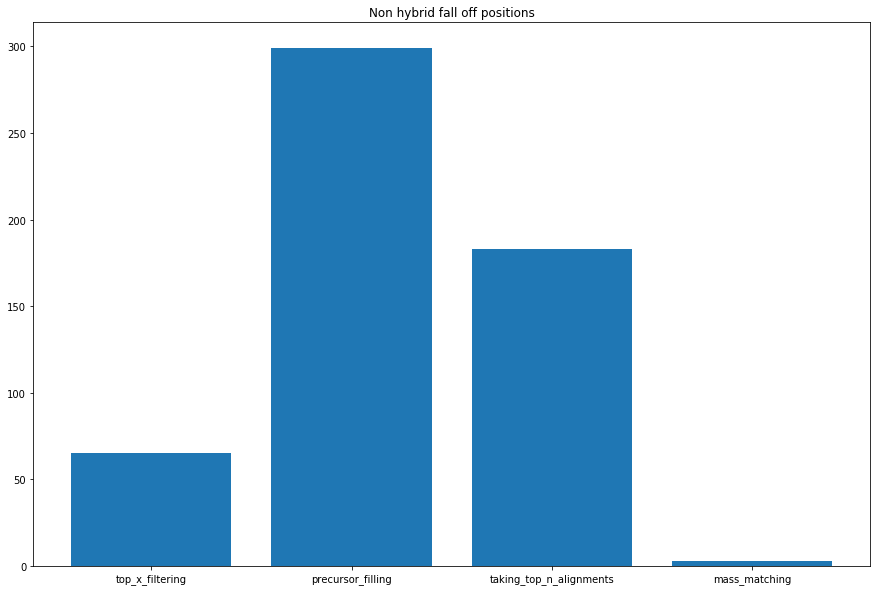

In [15]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(nonhybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Non hybrid fall off positions')

### Hybrid analysis

In [16]:
precursor_fall_offs = [x for x in hybrid_typed_fall_off['precursor_filling']]

In [17]:
for pfo in precursor_fall_offs:
    t_seq = pfo[1]['truth_sequence']
        
    print(f'Truth sequence: {t_seq}')
    print('Before\n===========================================')
    for x in pfo[1]['meta_data']['sequences_before_precursor_filling']:
        if x[0][:2] == t_seq[:2] and x[0][-2:] == t_seq[-2:]:
            print(x)
            
    print('After\n===========================================')
    for x in pfo[1]['meta_data']['sequences_after_precursor_filling']:
        if x[0][:1] == t_seq[:1] and x[0][-1:] == t_seq[-1:]:
            print(x)
            
    print()

Truth sequence: DLQTL-EVE
Before
['DLQTLGAPVE', 'DLQTL-GAPVE']
['DLQTLAEPEEVE', 'DLQT(L)AEPEEVE']
['DLQTLHTLDVE', 'DLQTL-HTLDVE']
['DLQTLFRNTNVE', 'DLQTL-FRNTNVE']
['DLQTLNPVE', 'DLQTL-NPVE']
['DLQTLPQVE', 'DLQTL-PQVE']
['DLQTLPNVE', 'DLQTL-PNVE']
['DLQTLINPVE', 'DLQTL-INPVE']
After



In [18]:
top_x_filtering = [x for x in hybrid_typed_fall_off['top_x_filtering']]

In [28]:
def is_close(truth, tried, ion, close_dist=2):
    if len(tried) > len(truth):
        return False
    
    if ion == 'b':
        return truth[:close_dist].replace('I', 'B').replace('L', 'B') == tried[:close_dist].replace('I', 'B').replace('L', 'B')
    else:
        return truth[-close_dist:].replace('I', 'B').replace('L', 'B') == tried[-close_dist:].replace('I', 'B').replace('L', 'B')
    
for _id, txf in top_x_filtering:
    t_seq = txf['truth_sequence']
    
    print(f'Truth sequence: {t_seq}')
    
    print('Kept b hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)

    print('Kept y hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print('Lost b hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)
            
    print('Lost y hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print()

Truth sequence: DLQTLAL-NAAR
Kept b hits close to correct half
DLQT
DLQDQL
Kept y hits close to correct half
Lost b hits close to correct half
DLQ
DIQ
DLQI
DLQL
DIQI
DLQNL
DIQVK
DIQVKE
Lost y hits close to correct half
ESKKAARAAR
NAAR
AARAAR
RAALAAR
EGPRCEVAAR
LCLALAWAAR



### Non hybrid analysis
As of NOV 12, it looks like precursor filling is the worst and ruining our chances. Lets look at the halves and see if we can determine why this step is ruining it

In [30]:
# get the precursor filling subjects
nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['precursor_filling']]

In [37]:
[x for x in nh_precursor_fall_off[0][1]['meta_data']['sequences_before_precursor_filling'] if x[0][-11:] == 'ANTTIGRIRFH']

[['SERLEANTTIGRIRFH', 'SERL(E)ANTTIGRIRFH'],
 ['SSARLGSFRAPRAGEANTTIGRIRFH', 'SSARLGSFRAPRAG-EANTTIGRIRFH'],
 ['TDDTFEANTTIGRIRFH', 'TDDT-FEANTTIGRIRFH'],
 ['TDKQEKKEVPKCFEANTTIGRIRFH', 'TDKQEKKEVPKC-FEANTTIGRIRFH'],
 ['EDAGEENFEANTTIGRIRFH', 'EDAGEE-NFEANTTIGRIRFH'],
 ['TTALLKIDITDTEFEANTTIGRIRFH', 'TTALLKIDITDTE-FEANTTIGRIRFH'],
 ['SESEANTTIGRIRFH', 'SES(E)ANTTIGRIRFH'],
 ['SLVTNFEANTTIGRIRFH', 'SLVT-NFEANTTIGRIRFH'],
 ['TVPPAAPAGEGGPPAPPPNFEANTTIGRIRFH', 'TVPPAAPAGEGGPPAPPPN-FEANTTIGRIRFH'],
 ['SSILNFEANTTIGRIRFH', 'SSIL-NFEANTTIGRIRFH'],
 ['TTFHKNFEANTTIGRIRFH', 'TTFHK-NFEANTTIGRIRFH'],
 ['SIQRSAPGGGGKRYFEANTTIGRIRFH', 'SIQRSAPGGGGKRY-FEANTTIGRIRFH'],
 ['SLVTFEANTTIGRIRFH', 'SLVT-FEANTTIGRIRFH'],
 ['SLEEREANTTIGRIRFH', 'SLEER-EANTTIGRIRFH'],
 ['SSIINFEANTTIGRIRFH', 'SSII-NFEANTTIGRIRFH'],
 ['TTTTTFKGEANTTIGRIRFH', 'TTTTTFKG-EANTTIGRIRFH'],
 ['SIQRSAPGGGGKRYEANTTIGRIRFH', 'SIQRSAPGGGGKRY-EANTTIGRIRFH'],
 ['SLSINFEANTTIGRIRFH', 'SLSI-NFEANTTIGRIRFH'],
 ['TTDDNFEANTTIGRIRFH', 'TTDD-NF

In [35]:
nh_precursor_fall_off[0][1]

{'hybrid': False,
 'truth_sequence': 'DEAPNFEANTTIGRIRFH',
 'fall_off_operation': 'precursor_filling',
 'meta_data': {'sequences_before_precursor_filling': [['TVDLWFKERVRMASPRGQ',
    'TVDLW-FKERVRMASPRGQ'],
   ['SLSIDDSP', 'SLSI-DDSP'],
   ['SSLLLEIWFDK', 'SSLLLE-IWFDK'],
   ['SILSGAGRDTLLGAKATPS', 'SILS-GAGRDTLLGAKATPS'],
   ['TDKQEKKEVPKCFSLHIDGKIFQEK', 'TDKQEKKEVPKC-FSLHIDGKIFQEK'],
   ['TVLSNVIQLVDVLYNEEK', 'TVLS-NVIQLVDVLYNEEK'],
   ['SETDFQNEVARQLISEK', 'SETD-FQNEVARQLISEK'],
   ['SSLLSTLTTYLQEK', 'SSLL-STLTTYLQEK'],
   ['SESENVIQLVDVLYNEEK', 'SESE-NVIQLVDVLYNEEK'],
   ['SSLISALLGQMQNVIQLVDVLYNEEK', 'SSLISALLGQMQ-NVIQLVDVLYNEEK'],
   ['TTDDIWFDK', 'TTDD-IWFDK'],
   ['SSLISALLGQMQGHKCIPPS', 'SSLISALLGQMQ-GHKCIPPS'],
   ['SIQRSAPGGGGKRYSLHIDGKIFQEK', 'SIQRSAPGGGGKRY-SLHIDGKIFQEK'],
   ['SEDTQNEVARQLISEK', 'SEDT-QNEVARQLISEK'],
   ['SIISVVPS', 'SIIS-VVPS'],
   ['SESEQVNELKEKGNK', 'SES(E)QVNELKEKGNK'],
   ['SESEKKGPGKNDNAEK', 'SES(E)KKGPGKNDNAEK'],
   ['SEDTASALRTASPQQR', 'SEDT-ASAL